In [1]:
# 加载模型

from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "xlnet/xlnet-base-cased" # "openai/gpt-oss-20b" # "Qwen/Qwen3-4B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)

/opt/miniconda3/envs/trans/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


In [5]:
analyse_layer = 0
analyse_head = 0

### 基础模型调用

In [6]:
# prepare the model input - directly input text and tokens
import torch

# text = " sink sink sink sink sink sink sink sink sink sink sink sink sink sink sink"
# text = " road road road road road road road road road road road road road road road"
text = "Once upon a time, in a land far, far away, there lived a young princess who dreamed of exploring the world beyond her castle walls."
# text = " Once sink sink sink sink sink sink sink sink sink sink sink sink sink sink sink"
# text = " sink Once sink sink sink sink sink sink sink sink sink sink sink sink sink sink"
# text = " Once Once sink sink sink sink sink sink sink sink sink sink sink sink sink sink"
print(f"Input text: {text}")

# tokenize the text to get token IDs
token_ids = tokenizer.encode(text, add_special_tokens=False)
print(f"Token IDs: {token_ids}")

# prepare model inputs directly from token IDs
input_ids = torch.tensor([token_ids], dtype=torch.long).to(model.device)
model_inputs = {"input_ids": input_ids}

# get model output without generation
with torch.no_grad():
    outputs = model(
        **model_inputs,
        output_attentions=True,
        output_hidden_states=True,
    )

# get the output logits (probability distribution)
logits = outputs.logits  # shape: [batch_size, sequence_length, vocab_size]
attentions = outputs.attentions  # tuple of attention weights for each layer
hidden_states = outputs.hidden_states  # tuple of hidden states for each layer


Input text: Once upon a time, in a land far, far away, there lived a young princess who dreamed of exploring the world beyond her castle walls.
Token IDs: [1977, 975, 24, 92, 19, 25, 24, 883, 420, 19, 420, 308, 19, 105, 2042, 24, 673, 14047, 61, 18251, 20, 10261, 18, 185, 1756, 62, 6413, 3396, 9]


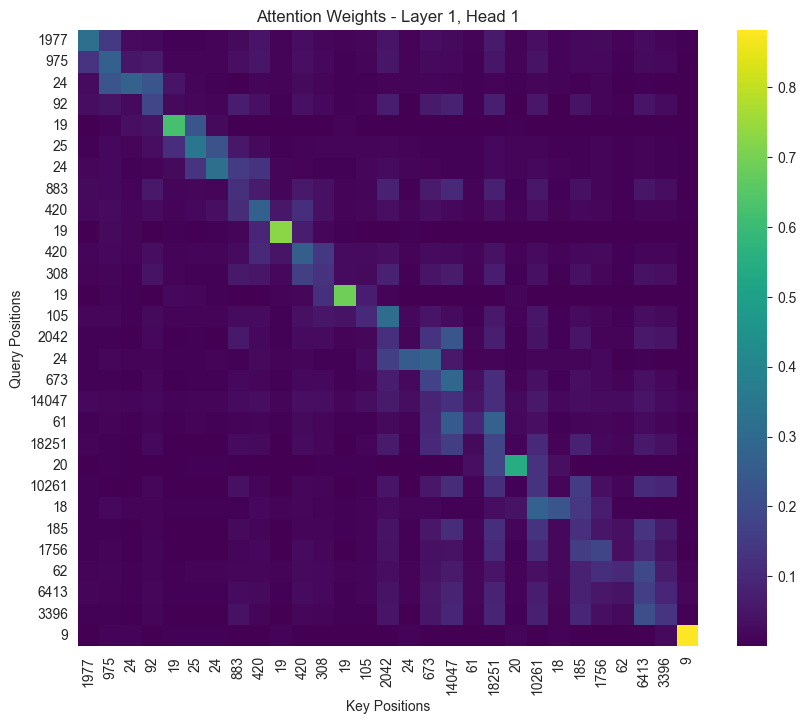

In [7]:
# 画出特定层的注意力权重热图
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_heatmap(attention, layer, head, token_ids):
    """
    Plot the attention heatmap for a specific layer and head.

    Args:
        attention (tuple): Tuple of attention weights for each layer.
        layer (int): Layer index to visualize.
        head (int): Head index to visualize.
        token_ids (list): List of token IDs for labeling the axes.
    """
    attn_weights = attention[layer][0, head].cpu().float().numpy()  # shape: [seq_len, seq_len]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_weights, xticklabels=token_ids, yticklabels=token_ids, cmap="viridis")
    plt.title(f"Attention Weights - Layer {layer+1}, Head {head+1}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

# plot attention heatmap for layer 0, head 0
plot_attention_heatmap(attentions, layer=analyse_layer, head=analyse_head, token_ids=token_ids)

### 打印qkv

In [130]:
# 获取指定层的QKV
import torch

# 直接从模型获取中间层的输出
with torch.no_grad():
    # 准备QKV存储
    qkv_outputs = {}
    
    # 运行完整的forward获取所有中间状态
    outputs = model(
        **model_inputs,
        output_attentions=True,
        output_hidden_states=True,
    )
    
    logits = outputs.logits
    attentions = outputs.attentions
    hidden_states_all = outputs.hidden_states
    
    # 从hidden_states获取指定层的输入
    # hidden_states_all包含每一层的输出，第0个是embedding，第analyse_layer个是第analyse_layer-1层的输出
    if analyse_layer == 0:
        layer_input = hidden_states_all[0]  # embedding层输出
    else:
        layer_input = hidden_states_all[analyse_layer]  # 前一层的输出
    
    # 获取指定层 - BLOOM使用transformer.h而不是model.layers
    layer = model.transformer.h[analyse_layer]
    
    # 应用layer norm - BLOOM使用input_layernorm
    normed_hidden_states = layer.input_layernorm(layer_input)
    
    # 获取QKV投影 - BLOOM使用self_attention.query_key_value
    # BLOOM将QKV合并在一起
    qkv = layer.self_attention.query_key_value(normed_hidden_states)
    
    # 分离Q, K, V
    # qkv shape: [batch_size, seq_len, 3 * hidden_size]
    hidden_size = normed_hidden_states.shape[-1]
    q, k, v = qkv.split(hidden_size, dim=-1)
    
    print(f"Layer {analyse_layer} QKV shapes:")
    print(f"  Hidden states: {normed_hidden_states.shape}")
    print(f"  Query: {q.shape}")
    print(f"  Key: {k.shape}")  
    print(f"  Value: {v.shape}")
    
    # 保存QKV
    qkv_outputs[f"Layer_{analyse_layer}"] = {
        'query': q.detach().cpu().float(),
        'key': k.detach().cpu().float(),
        'value': v.detach().cpu().float(),
        'hidden_states': normed_hidden_states.detach().cpu().float()
    }

print(f"\nSuccessfully captured QKV for layer {analyse_layer}")

Layer 21 QKV shapes:
  Hidden states: torch.Size([1, 30, 1024])
  Query: torch.Size([1, 30, 1024])
  Key: torch.Size([1, 30, 1024])
  Value: torch.Size([1, 30, 1024])

Successfully captured QKV for layer 21


In [131]:
# 查看特定层的QKV值 - 简单概览
if f"Layer_{analyse_layer}" in qkv_outputs:
    layer_qkv = qkv_outputs[f"Layer_{analyse_layer}"]
    print(f"Layer {analyse_layer} QKV tensors:")
    print(f"Query shape: {layer_qkv['query'].shape}")
    print(f"Key shape: {layer_qkv['key'].shape}")
    print(f"Value shape: {layer_qkv['value'].shape}")
else:
    print(f"Layer {analyse_layer} not found in qkv_outputs")

Layer 21 QKV tensors:
Query shape: torch.Size([1, 30, 1024])
Key shape: torch.Size([1, 30, 1024])
Value shape: torch.Size([1, 30, 1024])


In [132]:
# 详细打印QKV值和注意力分数
if f"Layer_{analyse_layer}" in qkv_outputs:
    layer_qkv = qkv_outputs[f"Layer_{analyse_layer}"]
    
    # 获取attention配置
    num_heads = model.config.num_attention_heads
    num_key_value_heads = model.config.num_key_value_heads if hasattr(model.config, 'num_key_value_heads') else num_heads
    
    # 获取QKV
    q = layer_qkv['query']  # [batch_size, seq_len, hidden_size]
    k = layer_qkv['key']    # [batch_size, seq_len, hidden_size]
    v = layer_qkv['value']  # [batch_size, seq_len, hidden_size]
    
    batch_size, seq_len, _ = q.shape
    head_dim = q.shape[-1] // num_heads
    kv_head_dim = k.shape[-1] // num_key_value_heads
    
    print(f"=== Layer {analyse_layer} QKV Analysis ===")
    print(f"Number of heads: {num_heads}")
    print(f"Number of KV heads: {num_key_value_heads}")
    print(f"Head dimension: {head_dim}")
    print(f"Sequence length: {seq_len}")
    
    # Reshape Q, K, V for multi-head attention
    q_reshaped = q.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
    k_reshaped = k.view(batch_size, seq_len, num_key_value_heads, kv_head_dim).transpose(1, 2)
    v_reshaped = v.view(batch_size, seq_len, num_key_value_heads, kv_head_dim).transpose(1, 2)
    
    # 如果num_key_value_heads != num_heads，需要重复K和V
    if num_key_value_heads != num_heads:
        num_groups = num_heads // num_key_value_heads
        k_reshaped = k_reshaped.repeat_interleave(num_groups, dim=1)
        v_reshaped = v_reshaped.repeat_interleave(num_groups, dim=1)
    
    # 获取特定head的QKV
    q_head = q_reshaped[:, analyse_head, :, :]  # [batch, seq_len, head_dim]
    k_head = k_reshaped[:, analyse_head, :, :]
    v_head = v_reshaped[:, analyse_head, :, :]
    
    print(f"\n=== Head {analyse_head} - Query vectors (first 10 dims) ===")
    for i in range(seq_len):
        token_id = token_ids[i]
        token_str = tokenizer.decode([token_id])
        print(f"Token {i:2d} (ID: {token_id:5d}, '{token_str:15s}'): {q_head[0, i, :10].numpy()}")
    
    print(f"\n=== Head {analyse_head} - Key vectors (first 10 dims) ===")
    for i in range(seq_len):
        token_id = token_ids[i]
        token_str = tokenizer.decode([token_id])
        print(f"Token {i:2d} (ID: {token_id:5d}, '{token_str:15s}'): {k_head[0, i, :10].numpy()}")
    
    print(f"\n=== Head {analyse_head} - Value vectors (first 10 dims) ===")
    for i in range(seq_len):
        token_id = token_ids[i]
        token_str = tokenizer.decode([token_id])
        print(f"Token {i:2d} (ID: {token_id:5d}, '{token_str:15s}'): {v_head[0, i, :10].numpy()}")
    
    # 计算并打印注意力分数
    scores = torch.matmul(q_head, k_head.transpose(-2, -1)) / (head_dim ** 0.5)
    print(f"\n=== Attention scores (head {analyse_head}) ===")
    print(f"Shape: {scores.shape}")
    print("\nScore matrix:")
    print(scores[0].numpy())

=== Layer 21 QKV Analysis ===
Number of heads: 16
Number of KV heads: 16
Head dimension: 64
Sequence length: 30

=== Head 12 - Query vectors (first 10 dims) ===
Token  0 (ID: 64393, 'Once           '): [-1.796875    1.5048828   0.4272461  -0.25463867 -3.875      -0.9892578
  0.69677734  1.7558594   0.33081055  2.3222656 ]
Token  1 (ID: 14591, ' upon          '): [-1.3125     -0.8378906  -0.4104004   1.2646484  -1.2382812   0.609375
 -1.0429688  -0.03652954  0.14575195 -0.27148438]
Token  2 (ID:   267, ' a             '): [-1.1035156  -0.05114746  0.07116699 -1.5488281  -0.97753906  0.42041016
 -0.6479492   0.37817383 -0.19262695  0.02584839]
Token  3 (ID:  3509, ' time          '): [-0.43920898 -0.1665039  -1.0341797  -0.38354492  0.09436035  0.88134766
 -0.9277344  -0.86816406 -0.2919922   1.234375  ]
Token  4 (ID:    15, ',              '): [-1.2021484   0.9472656   0.36987305 -0.3564453   0.58740234  2.1757812
 -1.8447266   0.04772949  0.11590576  0.8676758 ]
Token  5 (ID:   361, ' 

In [133]:
# 计算并打印QKV向量的模长和方差
if f"Layer_{analyse_layer}" in qkv_outputs:
    layer_qkv = qkv_outputs[f"Layer_{analyse_layer}"]
    
    # 获取attention配置
    num_heads = model.config.num_attention_heads
    num_key_value_heads = model.config.num_key_value_heads if hasattr(model.config, 'num_key_value_heads') else num_heads
    
    # 获取QKV
    q = layer_qkv['query']  # [batch_size, seq_len, hidden_size]
    k = layer_qkv['key']
    v = layer_qkv['value']
    
    batch_size, seq_len, _ = q.shape
    head_dim = q.shape[-1] // num_heads
    kv_head_dim = k.shape[-1] // num_key_value_heads
    
    # Reshape Q, K, V for multi-head attention
    q_reshaped = q.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
    k_reshaped = k.view(batch_size, seq_len, num_key_value_heads, kv_head_dim).transpose(1, 2)
    v_reshaped = v.view(batch_size, seq_len, num_key_value_heads, kv_head_dim).transpose(1, 2)
    
    # 如果num_key_value_heads != num_heads，需要重复K和V
    if num_key_value_heads != num_heads:
        num_groups = num_heads // num_key_value_heads
        k_reshaped = k_reshaped.repeat_interleave(num_groups, dim=1)
        v_reshaped = v_reshaped.repeat_interleave(num_groups, dim=1)
    
    # 获取特定head的QKV
    q_head = q_reshaped[:, analyse_head, :, :]  # [batch, seq_len, head_dim]
    k_head = k_reshaped[:, analyse_head, :, :]
    v_head = v_reshaped[:, analyse_head, :, :]
    
    # 计算向量模长
    q_norms = torch.norm(q_head[0], dim=-1)  # [seq_len]
    k_norms = torch.norm(k_head[0], dim=-1)
    v_norms = torch.norm(v_head[0], dim=-1)
    
    # 计算向量方差
    q_vars = torch.var(q_head[0], dim=-1)  # [seq_len]
    k_vars = torch.var(k_head[0], dim=-1)
    v_vars = torch.var(v_head[0], dim=-1)
    
    print(f"=== Layer {analyse_layer}, Head {analyse_head} - Vector Norms and Variances ===")
    print("\n{:<5} {:<6} {:<20} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format(
        "Idx", "ID", "Token", "Q Norm", "K Norm", "V Norm", "Q Var", "K Var", "V Var"))
    print("-" * 120)
    
    for i in range(seq_len):
        token_id = token_ids[i]
        token_str = tokenizer.decode([token_id])
        print(f"{i:<5} {token_id:<6} {token_str:<20} {q_norms[i]:<12.4f} {k_norms[i]:<12.4f} {v_norms[i]:<12.4f} {q_vars[i]:<12.4f} {k_vars[i]:<12.4f} {v_vars[i]:<12.4f}")
    
    # 统计信息
    print("\n=== Statistics ===")
    print("Norms:")
    print(f"  Query - Mean: {q_norms.mean():.4f}, Std: {q_norms.std():.4f}, Min: {q_norms.min():.4f}, Max: {q_norms.max():.4f}")
    print(f"  Key   - Mean: {k_norms.mean():.4f}, Std: {k_norms.std():.4f}, Min: {k_norms.min():.4f}, Max: {k_norms.max():.4f}")
    print(f"  Value - Mean: {v_norms.mean():.4f}, Std: {v_norms.std():.4f}, Min: {v_norms.min():.4f}, Max: {v_norms.max():.4f}")
    
    print("\nVariances:")
    print(f"  Query - Mean: {q_vars.mean():.4f}, Std: {q_vars.std():.4f}, Min: {q_vars.min():.4f}, Max: {q_vars.max():.4f}")
    print(f"  Key   - Mean: {k_vars.mean():.4f}, Std: {k_vars.std():.4f}, Min: {k_vars.min():.4f}, Max: {k_vars.max():.4f}")
    print(f"  Value - Mean: {v_vars.mean():.4f}, Std: {v_vars.std():.4f}, Min: {v_vars.min():.4f}, Max: {v_vars.max():.4f}")

=== Layer 21, Head 12 - Vector Norms and Variances ===

Idx   ID     Token                Q Norm       K Norm       V Norm       Q Var        K Var        V Var       
------------------------------------------------------------------------------------------------------------------------
0     64393  Once                 12.2122      54.7585      0.7151       2.3472       46.3678      0.0079      
1     14591   upon                8.8292       60.4001      8.5711       1.1676       56.7265      1.1313      
2     267     a                   8.2902       61.9825      8.4774       1.0539       59.9102      1.1238      
3     3509    time                7.9895       60.8236      11.5238      1.0117       57.6174      2.1040      
4     15     ,                    8.0802       61.2640      9.3383       1.0290       58.4121      1.3799      
5     361     in                  8.5366       61.7010      8.6282       1.1523       59.3202      1.1797      
6     267     a                   8.744